In [1]:
import numpy as np
from baselines.scripts.variable_density_swiss_roll import non_uniform_swiss
seeds = [20251106, 20251108]

In [2]:
N = 2000
K = 50
np.random.seed(seeds[0])
X, t = non_uniform_swiss(2, 1, .2, N, K=K, dim=3)

Here's a plot of the swiss roll data.

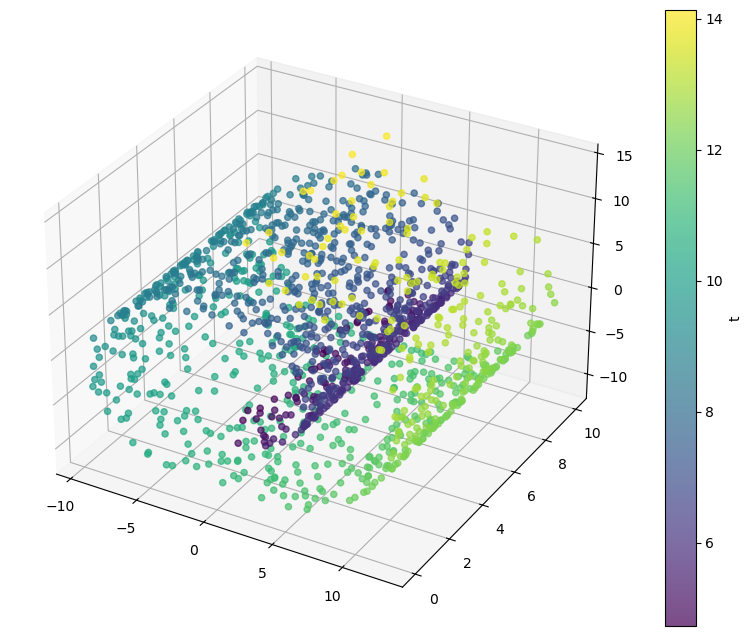

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, s=20, alpha=0.7, cmap='viridis')
plt.colorbar(sc, ax=ax, label='t')
plt.show()

In [4]:
import altair as alt
import pandas as pd

def plot_swiss_emb(X_emb, t):
    df_emb = pd.DataFrame(X_emb, columns=['x', 'y'])
    df_emb["t"] = t
    return alt.Chart(df_emb).mark_circle(size=60).encode(
        x='x',
        y='y',
        color='t'
    ).properties(width=400, height=300)

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=seeds[0], learning_rate='auto')
Z1 = tsne.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=50, random_state=seeds[1], learning_rate='auto')
Z2 = tsne.fit_transform(X)

In [18]:
plots = [
    plot_swiss_emb(Z1, t),
    plot_swiss_emb(Z2, t)
]

[display(p) for p in plots]

alt.Chart(...)

alt.Chart(...)

[None, None]